# Implement Online portfolio algorithms directly into the Gyn environment

In [79]:
from stable_baselines3.common.type_aliases import GymEnv
from typing import Any, Dict, Optional, Tuple, Union, List

import numpy as np
import pandas as pd


class UPModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            number_of_portfolios=10000, # Number of randomly generated CRP portfolios
            ) -> None:

        # Generate many crp protfolios rnadomly, and choose weights from the best portfolio

        assert env is not None 
        self.env = env

        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # The algorithm does not hold cash
        self.number_of_stocks = self.portfolio_length - 1

        a = np.sort(np.random.random((number_of_portfolios, self.number_of_stocks - 1)))
        a = np.hstack([np.zeros((number_of_portfolios, 1)), a, np.ones((number_of_portfolios, 1))])

        # create set of CRPs
        self.crp_weights = np.matrix(np.diff(a))
        self.crp_wealth = np.matrix(np.ones(self.crp_weights.shape[0])).T

        # TODO we do not use keverage in this equation

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'train' on a benchmark model, use predict instead. These models are deterministic.")

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'learn' on a benchmark model, use predict instead. These models are deterministic.")

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # This assumes the close prices are in the environment.
        # This will break if close prices are not first in the environment
        # TODO fix this
        prices = reshaped_array[0].tolist()
        self.crp_wealth = np.multiply(self.crp_wealth, self.crp_weights * np.matrix(prices).T)

        print(self.crp_wealth)
        print("Dimensions of the self.crp_wealth:", self.crp_wealth)

        # The performance is the weighted average of all CRP portfolios
        new_weights = self.crp_weights.T * self.crp_wealth

        print(new_weights)
        print("Dimensions of the new_weights:", new_weights)

        new_weights = new_weights / sum(new_weights)

        self.current_weights = np.array(new_weights)

        
        print(self.current_weights)
        print("Dimensions of the array:", self.current_weights.shape)

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Algo does not hold cash
        action_weights = np.insert(self.current_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

In [80]:


MODELS = {"up": UPModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
           
            action, _states = model.predict(test_obs, deterministic=deterministic)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [81]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2009-01-01'
TEST_END_DATE = '2024-10-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment = PortfolioOptimizationEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

UP_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

UP_model_kwargs = {
    
}

# Training
agent_up = DRLStableAgent(env = environment)
model_up = agent_up.get_model("up", model_kwargs=UP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_up, environment)
UP_results["training"] = environment._terminal_asset_memory["final"]
UP_results["date"] = environment._terminal_date_memory



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (114898, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.39660606 0.62818164 0.68543954 ... 0.01947727 0.01808933 0.02899626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.   0.   0.25 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: 

[[0.12620987]
 [0.12961084]
 [0.11859918]
 ...
 [0.12286939]
 [0.13729008]
 [0.14116973]]
Dimensions of the self.crp_wealth: [[0.12620987]
 [0.12961084]
 [0.11859918]
 ...
 [0.12286939]
 [0.13729008]
 [0.14116973]]
[[42.66676088]
 [44.47384833]
 [43.18605473]
 [43.48633811]
 [43.16436011]
 [43.39182713]
 [45.23264501]
 [45.29696017]
 [44.13265079]
 [45.20508945]
 [43.65022337]
 [44.51430227]
 [44.87707811]
 [44.08829006]
 [45.281975  ]
 [44.70812428]
 [44.96147637]
 [43.52390945]
 [44.47440287]
 [43.74658743]
 [43.23705732]
 [43.42649125]
 [44.3431251 ]
 [43.84444927]
 [43.34550843]
 [43.21478396]
 [46.91597298]
 [45.64137638]
 [44.67588402]]
Dimensions of the new_weights: [[42.66676088]
 [44.47384833]
 [43.18605473]
 [43.48633811]
 [43.16436011]
 [43.39182713]
 [45.23264501]
 [45.29696017]
 [44.13265079]
 [45.20508945]
 [43.65022337]
 [44.51430227]
 [44.87707811]
 [44.08829006]
 [45.281975  ]
 [44.70812428]
 [44.96147637]
 [43.52390945]
 [44.47440287]
 [43.74658743]
 [43.23705732]
 [4

C:\Users\bencj\AppData\Local\Temp\ipykernel_8404\3544583482.py:85: RuntimeWarning: invalid value encountered in divide
  new_weights = new_weights / sum(new_weights)


AssertionError: The array does not sum up to one.

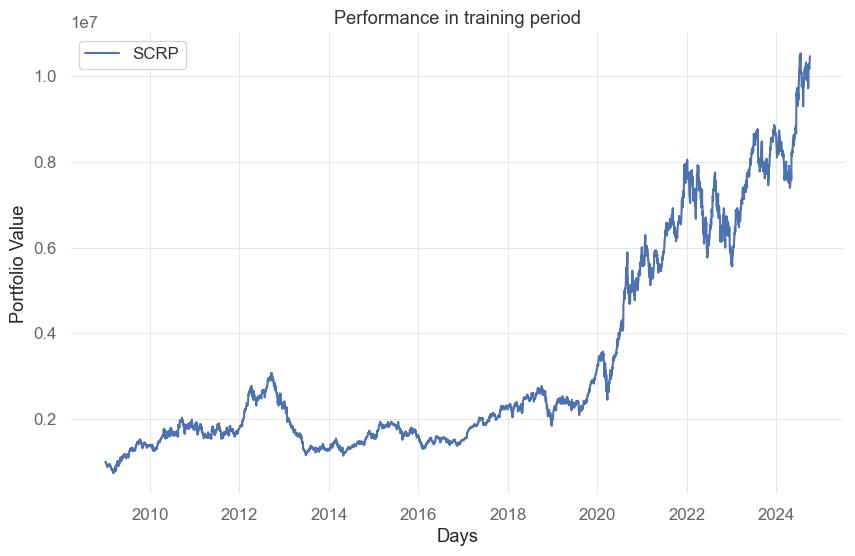

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UP_results["date"], UP_results["training"], label="UP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()